### Knowledge Distillation на CIFAR-100
Идея: обучаем "teacher" (большая модель), "student" (маленькая модель) и "student_kd" (ученик с учителем).
Потом сравниваем:
   1) teacher (обычное обучение)
   2) student baseline (обычное обучение)
   3) student KD (обучение с подсказками teacher через KL-div + temperature)


In [1]:
# - random / numpy: фиксация случайности и подготовка данных
import random, os
import numpy as np
# - torch / torch.nn: модель, обучение, функции потерь
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
# - torchvision: CIFAR-100 + трансформации + готовые ResNet
import torchvision
import torchvision.transforms as T
from torchvision.models import resnet50, resnet18
# - tqdm: прогресс-бар по батчам
from tqdm.auto import tqdm


Повторяемость эксперимента


Фиксируем seed, чтобы результаты меньше "прыгали" между запусками


Важно: даже с seed на GPU иногда остаётся небольшая недетерминированность, но здесь мы её максимально уменьшаем

In [2]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
# стараемся получить одинаковые результаты (может замедлить)
torch.backends.cudnn.deterministic = True
# отключаем автоподбор самых быстрых алгоритмов
torch.backends.cudnn.benchmark = False
# Выбираем устройство:
# - если есть CUDA -> обучаем на GPU
# - иначе -> CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# AMP (Automatic Mixed Precision):
# смешанная точность ускоряет обучение на GPU и экономит память.
amp_enabled = device.type == "cuda"
print(device, amp_enabled)


cuda True


Подсчёт mean/std по train части CIFAR-100

Это нужно для нормализации (Normalize), чтобы обучение было стабильнее

Считаем один раз, потом используем эти числа в аугментациях

Важно: это может занимать время, поэтому обычно mean/std "кэшируют" и больше не считают каждый запуск

In [3]:
def compute_mean_std():
    ds = torchvision.datasets.CIFAR100(root="./data", train=True, download=True, transform=T.ToTensor())
    dl = DataLoader(ds, batch_size=256, shuffle=False, num_workers=2)

    s1 = torch.zeros(3, dtype=torch.float64)
    s2 = torch.zeros(3, dtype=torch.float64)
    n = 0

    for x, _ in dl:
        x = x.to(torch.float64)
        b, c, h, w = x.shape
        # Накапливаем сумму и сумму квадратов по каналам (R,G,B)
        # x имеет форму [batch, channels, height, width]
        # n — общее количество пикселей (batch * h * w)
        s1 += x.sum(dim=(0, 2, 3))
        s2 += (x * x).sum(dim=(0, 2, 3))
        n += b * h * w

    mean = (s1 / n).to(torch.float32)
    # var = E[x^2] - (E[x])^2
    # clamp_min(0) — защита от отрицательных значений из-за округления float
    var = (s2 / n - mean.to(torch.float64) ** 2).clamp_min(0).to(torch.float32)
    std = torch.sqrt(var)
    return tuple(mean.tolist()), tuple(std.tolist())

# Запускаем подсчёт mean/std.
# Если ты уже один раз посчитал и записал значения — можно закомментировать вызов и вставить числа вручную.
mean, std = compute_mean_std()
mean, std


Files already downloaded and verified


((0.5070751905441284, 0.48654887080192566, 0.44091784954071045),
 (0.2673342525959015, 0.2564384937286377, 0.2761504650115967))

Аугментации

Train: делаем небольшие искажения (crop/flip), чтобы модель лучше обобщала

Test: никаких искажений, только приведение к тензору и нормализация

In [4]:
train_tfms = T.Compose([T.RandomCrop(32, padding=4), T.RandomHorizontalFlip(), T.ToTensor(), T.Normalize(mean, std)])
test_tfms  = T.Compose([T.ToTensor(), T.Normalize(mean, std)])

train_ds = torchvision.datasets.CIFAR100(root="./data", train=True, download=True, transform=train_tfms)
test_ds  = torchvision.datasets.CIFAR100(root="./data", train=False, download=True, transform=test_tfms)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=128, shuffle=False, num_workers=2, pin_memory=True)

# - batch_size: сколько картинок в одном батче
# - shuffle=True для train, чтобы модель не видела данные всегда в одном порядке
# - num_workers: параллельная загрузка
# - pin_memory=True ускоряет копирование на GPU (если CUDA)

len(train_ds), len(test_ds)


Files already downloaded and verified
Files already downloaded and verified


(50000, 10000)

Teacher — более мощная сеть, которая достигает большей точности


В distillation teacher выступает как "источник подсказок": student учится повторять его распределения вероятностей

In [5]:
class Teacher(nn.Module):
    def __init__(self):
        super().__init__()
        m = resnet50(weights=None)
        m.conv1 = nn.Conv2d(3, 64, 3, 1, 1, bias=False)
        m.maxpool = nn.Identity()
        # ResNet из torchvision рассчитан на ImageNet (224x224).
        # CIFAR-100 — 32x32, поэтому:
        # - уменьшаем conv1 (kernel=3, stride=1), чтобы не "убить" картинку в самом начале
        # - убираем maxpool (Identity), иначе слишком быстро уменьшится размер карты признаков, нормальных данных мы не получим
        # - меняем последний fc на 100 классов (CIFAR-100)
        m.fc = nn.Linear(m.fc.in_features, 100)
        self.m = m
    def forward(self, x):
        return self.m(x)

# class Teacher(nn.Module):
#     def __init__(self):
#         super().__init__()
#         m = resnet18(weights=None)
#         m.conv1 = nn.Conv2d(3, 64, 3, 1, 1, bias=False)
#         m.maxpool = nn.Identity()
#         m.fc = nn.Linear(m.fc.in_features, 100)
#         self.m = m
#
#     def forward(self, x):
#         return self.m(x)


Student модель

Небольшая CNN: быстрее и легче teacher, но обычно менее точная

Наша цель: улучшить student через KD (knowledge distillation)


In [ ]:
class Student(nn.Module):
    def __init__(self):
        super().__init__()
        self.f = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2),
        # Сверточные блоки:
        # Conv -> извлекает признаки
        # BatchNorm -> стабилизирует обучение
        # ReLU -> нелинейность
        # MaxPool(2) -> уменьшение размера в 2 раза (32->16->8->4)
        )
        # Классификатор:
        # После 3 MaxPool размер становится 4x4, каналов 128 => 128*4*4 входов в Linear
        self.h = nn.Sequential(nn.Flatten(), nn.Linear(128*4*4, 256), nn.ReLU(), nn.Linear(256, 100))
    def forward(self, x):
        return self.h(self.f(x))

Оценка accuracy

torch.no_grad(): отключаем вычисление градиентов -> быстрее и меньше памяти ест

In [6]:
@torch.no_grad()
def eval_acc(model):
    model.eval()
    # - BatchNorm использует накопленную статистику
    # - Dropout отключается
    ok, total = 0, 0
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        p = model(x).argmax(1)
        # logits -> выбираем индекс максимального класса (argmax)
        # сравниваем с y и считаем количество правильных ответов
        ok += (p == y).sum().item()
        total += y.numel()
    return ok / total


Обычное обучение (supervised)

Учим модель по CrossEntropyLoss на истинных метках

Возвращаем историю train/test accuracy по эпохам — для сравнения на графике

In [7]:
def train_supervised(model, epochs, lr, wd):
    model.to(device)
    # SGD + momentum — оптимизатор для ResNet
    # weight_decay — L2-регуляризация, защита от переобучения
    # CosineAnnealingLR — плавно уменьшает lr по косинусу на протяжении epochs
    opt = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=wd)
    sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=epochs)
    # GradScaler нужен для AMP:
    # масштабирует loss, чтобы избежать слишком маленьких градиентов
    scaler = torch.cuda.amp.GradScaler(enabled=amp_enabled)
    loss_fn = nn.CrossEntropyLoss()

    train_acc_hist = []
    test_acc_hist = []

    for e in range(1, epochs+1):
        model.train()
        correct, total = 0, 0

        pbar = tqdm(train_loader, desc=f"epoch {e}/{epochs}")
        for x, y in pbar:
            x, y = x.to(device), y.to(device)
            # Обнуляем градиенты перед backward.
            # set_to_none=True — чуть быстрее и экономит память.
            opt.zero_grad(set_to_none=True)
            # autocast: часть операций в float16 (быстрее на GPU),
            # часть оставляем в float32 (чтобы не ломалась точность).
            with torch.cuda.amp.autocast(enabled=amp_enabled):
                logits = model(x)
                loss = loss_fn(logits, y)
            # Шаг обучения с AMP:
            # 1) scaler.scale(loss).backward()
            # 2) scaler.step(opt)
            # 3) scaler.update()
            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()

            correct += (logits.argmax(1) == y).sum().item()
            total += y.numel()
        # Обновляем learning rate по расписанию (scheduler) раз в эпоху
        sch.step()

        train_acc = correct / total
        test_acc = eval_acc(model)

        train_acc_hist.append(train_acc)
        test_acc_hist.append(test_acc)

        print(f"epoch {e}: train_acc={train_acc:.4f} test_acc={test_acc:.4f}")

    return train_acc_hist, test_acc_hist


In [8]:
# Обучаем teacher: это "верхняя планка" по качеству и источник soft-targets для KD
teacher = Teacher()
teacher_train, teacher_test = train_supervised(teacher, 20, 0.1, 5e-4)
# teacher_acc


C:\Users\vales\AppData\Local\Temp\ipykernel_38864\2444045889.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=amp_enabled)


epoch 1/20:   0%|          | 0/391 [00:05<?, ?it/s]

C:\Users\vales\AppData\Local\Temp\ipykernel_38864\2444045889.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=amp_enabled):


epoch 1: train_acc=0.0925 test_acc=0.1396


epoch 2/20:   0%|          | 0/391 [00:05<?, ?it/s]

epoch 2: train_acc=0.1986 test_acc=0.2224


epoch 3/20:   0%|          | 0/391 [00:06<?, ?it/s]

epoch 3: train_acc=0.2913 test_acc=0.2588


epoch 4/20:   0%|          | 0/391 [00:05<?, ?it/s]

epoch 4: train_acc=0.3882 test_acc=0.3747


epoch 5/20:   0%|          | 0/391 [00:05<?, ?it/s]

epoch 5: train_acc=0.4575 test_acc=0.4617


epoch 6/20:   0%|          | 0/391 [00:05<?, ?it/s]

epoch 6: train_acc=0.5075 test_acc=0.4635


epoch 7/20:   0%|          | 0/391 [00:06<?, ?it/s]

epoch 7: train_acc=0.5449 test_acc=0.4791


epoch 8/20:   0%|          | 0/391 [00:05<?, ?it/s]

epoch 8: train_acc=0.5771 test_acc=0.5249


epoch 9/20:   0%|          | 0/391 [00:05<?, ?it/s]

epoch 9: train_acc=0.6095 test_acc=0.5281


epoch 10/20:   0%|          | 0/391 [00:05<?, ?it/s]

epoch 10: train_acc=0.6360 test_acc=0.5319


epoch 11/20:   0%|          | 0/391 [00:05<?, ?it/s]

epoch 11: train_acc=0.6651 test_acc=0.6012


epoch 12/20:   0%|          | 0/391 [00:05<?, ?it/s]

epoch 12: train_acc=0.6950 test_acc=0.5764


epoch 13/20:   0%|          | 0/391 [00:05<?, ?it/s]

epoch 13: train_acc=0.7263 test_acc=0.6313


epoch 14/20:   0%|          | 0/391 [00:06<?, ?it/s]

epoch 14: train_acc=0.7632 test_acc=0.6497


epoch 15/20:   0%|          | 0/391 [00:05<?, ?it/s]

epoch 15: train_acc=0.8025 test_acc=0.6706


epoch 16/20:   0%|          | 0/391 [00:06<?, ?it/s]

epoch 16: train_acc=0.8371 test_acc=0.6951


epoch 17/20:   0%|          | 0/391 [00:05<?, ?it/s]

epoch 17: train_acc=0.8756 test_acc=0.7094


epoch 18/20:   0%|          | 0/391 [00:06<?, ?it/s]

epoch 18: train_acc=0.9039 test_acc=0.7184


epoch 19/20:   0%|          | 0/391 [00:05<?, ?it/s]

epoch 19: train_acc=0.9254 test_acc=0.7273


epoch 20/20:   0%|          | 0/391 [00:06<?, ?it/s]

epoch 20: train_acc=0.9356 test_acc=0.7285


In [15]:
# Student baseline: учится обычным CrossEntropy без подсказок teacher
# Нужен для сравнения с KD
student_base = Student()
base_train, base_test = train_supervised(student_base, 20, 0.05, 1e-4)
# base_acc


C:\Users\vales\AppData\Local\Temp\ipykernel_38864\2444045889.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=amp_enabled)


epoch 1/20:   0%|          | 0/391 [00:05<?, ?it/s]

C:\Users\vales\AppData\Local\Temp\ipykernel_38864\2444045889.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=amp_enabled):


epoch 1: train_acc=0.1155 test_acc=0.1959


epoch 2/20:   0%|          | 0/391 [00:05<?, ?it/s]

epoch 2: train_acc=0.2260 test_acc=0.2847


epoch 3/20:   0%|          | 0/391 [00:05<?, ?it/s]

epoch 3: train_acc=0.3033 test_acc=0.3440


epoch 4/20:   0%|          | 0/391 [00:05<?, ?it/s]

epoch 4: train_acc=0.3455 test_acc=0.3660


epoch 5/20:   0%|          | 0/391 [00:05<?, ?it/s]

epoch 5: train_acc=0.3800 test_acc=0.3970


epoch 6/20:   0%|          | 0/391 [00:05<?, ?it/s]

epoch 6: train_acc=0.4097 test_acc=0.4277


epoch 7/20:   0%|          | 0/391 [00:05<?, ?it/s]

epoch 7: train_acc=0.4345 test_acc=0.4423


epoch 8/20:   0%|          | 0/391 [00:05<?, ?it/s]

epoch 8: train_acc=0.4528 test_acc=0.4360


epoch 9/20:   0%|          | 0/391 [00:05<?, ?it/s]

epoch 9: train_acc=0.4697 test_acc=0.4570


epoch 10/20:   0%|          | 0/391 [00:05<?, ?it/s]

epoch 10: train_acc=0.4910 test_acc=0.4955


epoch 11/20:   0%|          | 0/391 [00:05<?, ?it/s]

epoch 11: train_acc=0.5027 test_acc=0.4874


epoch 12/20:   0%|          | 0/391 [00:05<?, ?it/s]

epoch 12: train_acc=0.5240 test_acc=0.4997


epoch 13/20:   0%|          | 0/391 [00:05<?, ?it/s]

epoch 13: train_acc=0.5357 test_acc=0.5160


epoch 14/20:   0%|          | 0/391 [00:05<?, ?it/s]

epoch 14: train_acc=0.5506 test_acc=0.5291


epoch 15/20:   0%|          | 0/391 [00:05<?, ?it/s]

epoch 15: train_acc=0.5645 test_acc=0.5345


epoch 16/20:   0%|          | 0/391 [00:05<?, ?it/s]

epoch 16: train_acc=0.5757 test_acc=0.5399


epoch 17/20:   0%|          | 0/391 [00:05<?, ?it/s]

epoch 17: train_acc=0.5885 test_acc=0.5446


epoch 18/20:   0%|          | 0/391 [00:05<?, ?it/s]

epoch 18: train_acc=0.5942 test_acc=0.5544


epoch 19/20:   0%|          | 0/391 [00:05<?, ?it/s]

epoch 19: train_acc=0.6014 test_acc=0.5570


epoch 20/20:   0%|          | 0/391 [00:05<?, ?it/s]

epoch 20: train_acc=0.6063 test_acc=0.5569


### Knowledge Distillation (KD)
Student учится по двум сигналам одновременно:
1) CE (CrossEntropy) по истинным меткам
2) KL-div между распределением student и teacher (soft-targets)

alpha  -> насколько важна часть KD (KL)

Ttemp  -> temperature: делает распределение "мягче" (больше информации о вторых/третьих классах)


In [10]:
def train_kd(student, teacher, epochs, lr, wd, alpha=0.7, Ttemp=4.0):
    student.to(device)
    teacher.to(device)
    teacher.eval()
    # "Замораживаем" teacher:
    # - teacher.eval() фиксирует BatchNorm/Dropout
    # - requires_grad=False запрещает считать градиенты для teacher (экономия памяти/скорости)
    for p in teacher.parameters():
        p.requires_grad = False

    opt = torch.optim.SGD(student.parameters(), lr=lr, momentum=0.9, weight_decay=wd)
    sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=epochs)
    scaler = torch.cuda.amp.GradScaler(enabled=amp_enabled)

    train_acc_hist = []
    test_acc_hist = []

    for e in range(1, epochs+1):
        student.train()
        correct, total = 0, 0

        pbar = tqdm(train_loader, desc=f"kd {e}/{epochs}")
        for x, y in pbar:
            x, y = x.to(device), y.to(device)
            opt.zero_grad(set_to_none=True)
            # Teacher logits считаем без градиентов (teacher не обучается на этом этапе)
            with torch.no_grad():
                t_logits = teacher(x)

            with torch.cuda.amp.autocast(enabled=amp_enabled):
                s_logits = student(x)
                ce = F.cross_entropy(s_logits, y)
                # KL-div для distillation:
                # - student: log_softmax(logits / T)
                # - teacher: softmax(logits / T)
                # Умножение на T^2 — стандартный трюк из KD, чтобы масштаб градиентов оставался адекватным.
                kl = F.kl_div(
                    F.log_softmax(s_logits / Ttemp, dim=1),
                    F.softmax(t_logits / Ttemp, dim=1),
                    reduction="batchmean"
                ) * (Ttemp * Ttemp)
                loss = alpha * kl + (1 - alpha) * ce
                # Итоговая функция потерь:
                # alpha ближе к 1 -> сильнее "слушаем teacher"
                # alpha ближе к 0 -> почти обычное supervised обучение

            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()

            correct += (s_logits.argmax(1) == y).sum().item()
            total += y.numel()

        sch.step()

        train_acc = correct / total
        test_acc = eval_acc(student)

        train_acc_hist.append(train_acc)
        test_acc_hist.append(test_acc)

        print(f"kd {e}: train_acc={train_acc:.4f} test_acc={test_acc:.4f}")

    return train_acc_hist, test_acc_hist



In [11]:
student_kd = Student()
kd_train, kd_test = train_kd(student_kd, teacher, epochs=20, lr=0.05, wd=1e-4)
# kd_acc


C:\Users\vales\AppData\Local\Temp\ipykernel_38864\167791215.py:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=amp_enabled)


kd 1/20:   0%|          | 0/391 [00:05<?, ?it/s]

C:\Users\vales\AppData\Local\Temp\ipykernel_38864\167791215.py:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=amp_enabled):


kd 1: train_acc=0.1498 test_acc=0.2455


kd 2/20:   0%|          | 0/391 [00:05<?, ?it/s]

kd 2: train_acc=0.2899 test_acc=0.3117


kd 3/20:   0%|          | 0/391 [00:05<?, ?it/s]

kd 3: train_acc=0.3590 test_acc=0.3962


kd 4/20:   0%|          | 0/391 [00:05<?, ?it/s]

kd 4: train_acc=0.4067 test_acc=0.4323


kd 5/20:   0%|          | 0/391 [00:05<?, ?it/s]

kd 5: train_acc=0.4388 test_acc=0.4616


kd 6/20:   0%|          | 0/391 [00:05<?, ?it/s]

kd 6: train_acc=0.4641 test_acc=0.4537


kd 7/20:   0%|          | 0/391 [00:05<?, ?it/s]

kd 7: train_acc=0.4874 test_acc=0.4805


kd 8/20:   0%|          | 0/391 [00:05<?, ?it/s]

kd 8: train_acc=0.5085 test_acc=0.5190


kd 9/20:   0%|          | 0/391 [00:05<?, ?it/s]

kd 9: train_acc=0.5215 test_acc=0.5270


kd 10/20:   0%|          | 0/391 [00:05<?, ?it/s]

kd 10: train_acc=0.5385 test_acc=0.5138


kd 11/20:   0%|          | 0/391 [00:05<?, ?it/s]

kd 11: train_acc=0.5559 test_acc=0.5488


kd 12/20:   0%|          | 0/391 [00:05<?, ?it/s]

kd 12: train_acc=0.5697 test_acc=0.5434


kd 13/20:   0%|          | 0/391 [00:05<?, ?it/s]

kd 13: train_acc=0.5802 test_acc=0.5584


kd 14/20:   0%|          | 0/391 [00:05<?, ?it/s]

kd 14: train_acc=0.5916 test_acc=0.5646


kd 15/20:   0%|          | 0/391 [00:05<?, ?it/s]

kd 15: train_acc=0.6013 test_acc=0.5758


kd 16/20:   0%|          | 0/391 [00:05<?, ?it/s]

kd 16: train_acc=0.6107 test_acc=0.5784


kd 17/20:   0%|          | 0/391 [00:05<?, ?it/s]

kd 17: train_acc=0.6134 test_acc=0.5848


kd 18/20:   0%|          | 0/391 [00:05<?, ?it/s]

kd 18: train_acc=0.6204 test_acc=0.5886


kd 19/20:   0%|          | 0/391 [00:05<?, ?it/s]

kd 19: train_acc=0.6204 test_acc=0.5884


kd 20/20:   0%|          | 0/391 [00:05<?, ?it/s]

kd 20: train_acc=0.6241 test_acc=0.5893


### Визуализация
Сравниваем train accuracy:
- Teacher (обычное обучение)
- Student baseline
- Student KD

По идее KD должен быть выше baseline (хотя зависит от гиперпараметров)

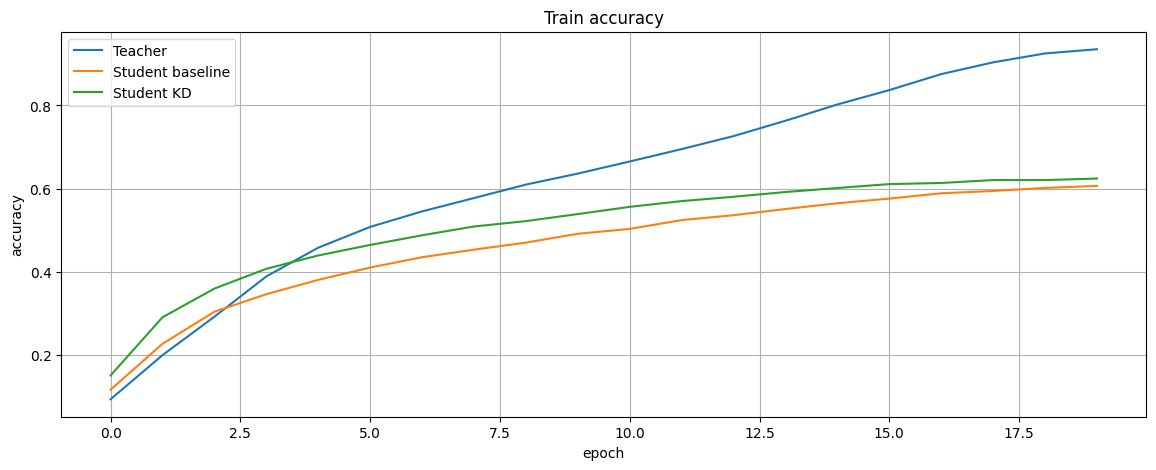

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))
plt.plot(teacher_train, label="Teacher")
plt.plot(base_train, label="Student baseline")
plt.plot(kd_train, label="Student KD")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Train accuracy")
plt.legend()
plt.grid(True)
plt.show()


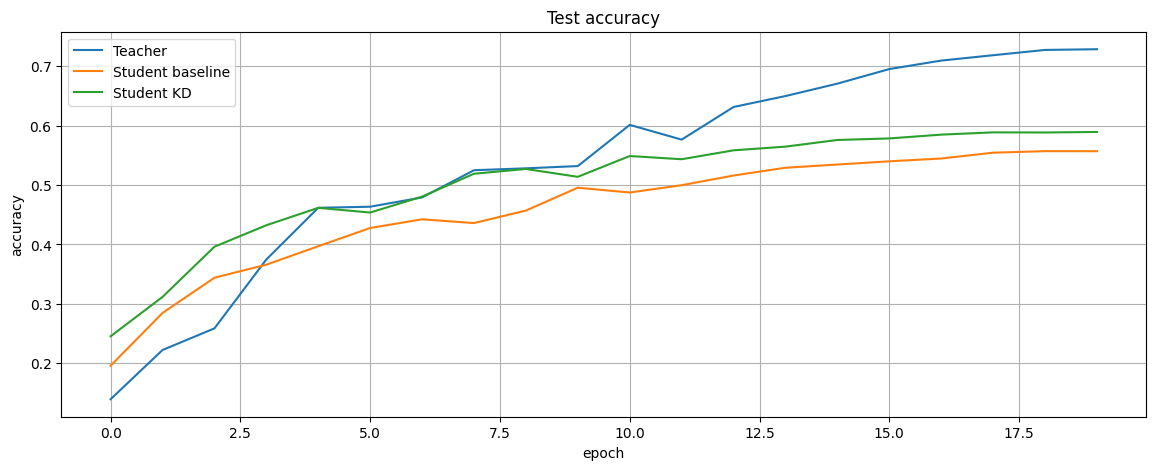

In [23]:
plt.figure(figsize=(14,5))
plt.plot(teacher_test, label="Teacher")
plt.plot(base_test, label="Student baseline")
plt.plot(kd_test, label="Student KD")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Test accuracy")
plt.legend()
plt.grid(True)
plt.show()
